In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt

import stretchablecorr as sc

In [2]:
from skimage.transform.pyramids import pyramid_reduce

In [35]:
ls ./images/

calib_bruit_camera_x11.5/  calibration/   PDMS_Amazon_18juin/
calib_bruit_camera_x2/     gris_e_zoom8/  PerlinNoise2D.png
calib_distortion_gris_x2/  HS2/


In [524]:
cube, image_names = sc.load_image_sequence('./images/HS2/')
#cube = cube[19:-1]
cube = cube[0:8]
print(cube.shape)

Load images from ./images/HS2/...
Image sequence:
 23 frames , 1392*1024 pixels , memory size: 250 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  55p000267.TIF
(8, 1024, 1392)


In [525]:
#points = np.array([[1100, 200], [600, 400]])

grid_spacing = 40
grid_margin = 150
# ----
grid = sc.build_grid(cube.shape[1:], margin=grid_margin, spacing=grid_spacing)
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

grid size: 28x19
 i.e. 532 points


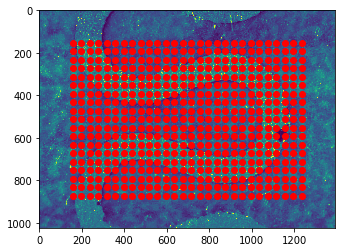

In [526]:
plt.imshow(cube[0]);
plt.plot(points[:, 0], points[:, 1], 'or');

In [527]:
downscale = 3
params = {'window_half_size': 23,
          'coarse_search': False,
          'phase':True,
          'method':'opti',
          'no_optim':False}

cube_reduced = [pyramid_reduce(I, downscale=downscale) for I in cube]
points_reduced = points/downscale

print(params['window_half_size']*downscale)
displ_coarse, err = sc.track_displ_img_to_img(cube_reduced, points_reduced, **params)
displ_coarse = displ_coarse*downscale

print('max displ:', np.sqrt(np.sum(displ_coarse**2, axis=-1)).max())

69
Compute image-to-image Lagrangian displacement field:
done                               
max displ: 1.6159654322649737


In [528]:
params = {'window_half_size': 15,
          'coarse_search': False,
          'phase':False,
          'method':'opti',
          'no_optim':False}
displ, gaps, err1, err2 = sc.track_displ_2steps(cube, points,
                                    offsets=displ_coarse,
                                    **params)

Compute image-to-image Lagrangian displacement field:
done                               
Compute image-to-image Lagrangian displacement field:
done                               
Compute image-to-image Lagrangian displacement field:
done                               


ValueError: x and y must have same first dimension, but have shapes (3192,) and (532,)

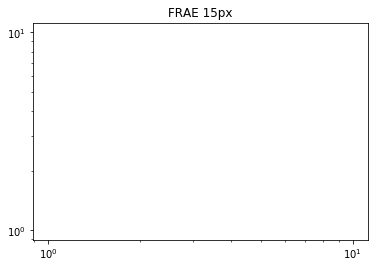

In [529]:
plt.title('FRAE ' + f"{params['window_half_size']}px");
plt.loglog(gaps.flatten(), np.sqrt(err1[0, :, 1]), '.g', alpha=0.5);
plt.loglog(gaps.flatten(), np.sqrt(err1[1, :, 1]), '.m', alpha=0.5);
plt.loglog(gaps.flatten(), np.sqrt(err2[0, :, 1]), '.b', alpha=0.5);
plt.loglog([1e-2, 1e-1], [1e-2, 1e-1], '-r')
plt.xlabel('gap error (px)');
plt.ylabel('estimation from Hessian (px)');

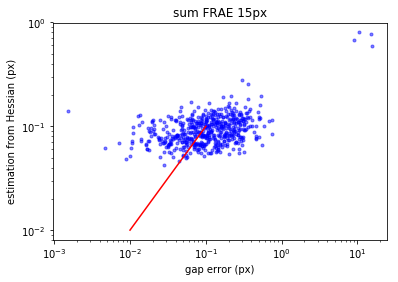

In [504]:
plt.title('sum FRAE ' + f"{params['window_half_size']}px");
plt.loglog(gaps.flatten(), np.sqrt(err2[0, :, 1]+err1[0, :, 1]+err1[1, :, 1]), '.b', alpha=0.5);
plt.loglog([1e-2, 1e-1], [1e-2, 1e-1], '-r')
plt.xlabel('gap error (px)');
plt.ylabel('estimation from Hessian (px)');

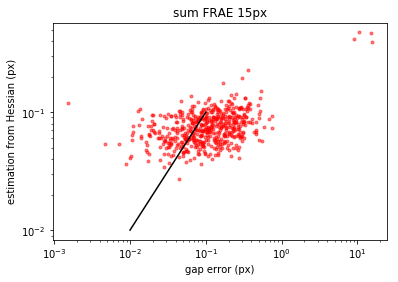

In [505]:
plt.title('sum FRAE ' + f"{params['window_half_size']}px");
plt.loglog(gaps.flatten(), np.sqrt(err2[0, :, 0]+err1[0, :, 0]+err1[1, :, 0]), '.r', alpha=0.5);
plt.loglog([1e-2, 1e-1], [1e-2, 1e-1], '-k')
plt.xlabel('gap error (px)');
plt.ylabel('estimation from Hessian (px)');

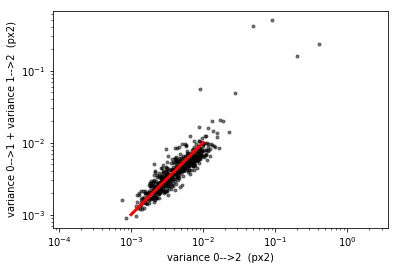

In [506]:
plt.loglog(err2[0, :, 1], err1[1, :, 1]+err1[0, :, 1], '.k', alpha=0.5)
plt.loglog([1e-3, 1e-2], [1e-3, 1e-2], '-r', linewidth=3)
plt.xlabel('variance 0-->2  (px2)');
plt.ylabel('variance 0-->1 + variance 1-->2  (px2)');
plt.axis('equal');

## Look at one point

In [507]:
argsorted = np.argsort(gaps[0].flatten())

pts = argsorted[-1]
print(pts, points[pts], gaps[0][pts])

514 [556 872] 15.666482858980945


displ_coarse[0, pts, :]--> [  0.07588994 -26.3628185 ]


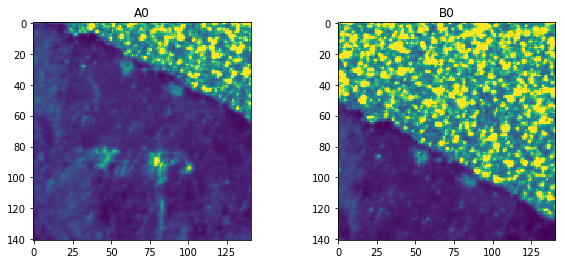

In [509]:
window_half_size = 70
A0, ij = sc.crop(cube[0], points[pts], window_half_size)
B0, ij = sc.crop(cube[1], points[pts]+displ_coarse[0, pts, :], window_half_size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.imshow(A0); ax1.set_title('A0');
ax2.imshow(B0); ax2.set_title('B0');
print('displ_coarse[0, pts, :]-->', displ_coarse[0, pts, :])

In [510]:
params = {'window_half_size': window_half_size,
          'coarse_search': False,
          'phase':False,
          'method':'opti',
          'no_optim':False}
displ_2, gaps_2, err1, err2 = sc.track_displ_2steps(cube, points[pts, None],
                                                    offsets=displ_coarse[:, pts, :],
                                                    **params)

print('----')
print('gap         ', gaps_2[0][0])
print('sqrt sum H-1', np.sqrt(err1[0, 0, 1]+err1[1, 0, 1]+err2[0, 0, 1]))
print('sqrt sum DF ', np.sqrt(err1[0, 0, 0]+err1[1, 0, 0]+err2[0, 0, 0]))

Compute image-to-image Lagrangian displacement field:
(2, 1, 2)
done                               
Compute image-to-image Lagrangian displacement field:
done                               
Compute image-to-image Lagrangian displacement field:
done                               
----
gap          31.939110172812057
sqrt sum H-1 0.16596967146771371
sqrt sum DF  0.06658804290367623


x_opt: [51.93399393  0.38394163]
ky 599792102.0
H0 605738032.2431086


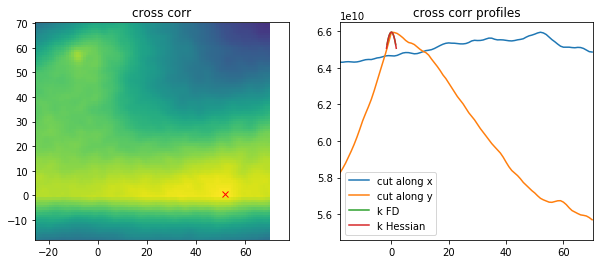

In [523]:
zoom_factor = 1
dx_span, dy_span, cross_corr, res = sc.output_cross_correlation(A0, B0,
                                                                upsamplefactor=1, phase=False)
x_opt = -res.x

argmax_idx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
argmax_idx_cc = argmax_idx

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.pcolor(dx_span, dy_span, np.log(cross_corr))
ax1.plot(*x_opt[::-1], 'xr'); 
ax1.axis('equal');
print('x_opt:', x_opt[::-1])
zoom_lim = int( zoom_factor*A0.shape[0]/2 )
ax1.set_title('cross corr');
ax1.set_xlim(np.array([-zoom_lim, zoom_lim]) + x_opt[::-1]);
ax1.set_ylim(np.array([-zoom_lim, zoom_lim]) + x_opt[::-1]);

ax2.set_title('cross corr profiles');
ax2.plot(dy_span, cross_corr[argmax_idx[0], :], label='cut along x');
ax2.plot(dx_span, cross_corr[:, argmax_idx[1]], label='cut along y'); ax2.legend();
ax2.set_xlim(np.array([-zoom_lim, zoom_lim]) + x_opt[::-1]);


ky = -(cross_corr[argmax_idx[0]+1, argmax_idx[1]] +\
      cross_corr[argmax_idx[0]-1, argmax_idx[1]] -\
      2*cross_corr[argmax_idx[0], argmax_idx[1]] )/np.diff(dy_span).mean()**2
x_peak = np.linspace(-1.5, 1.5, 55)
y = np.max(cross_corr) - 0.5*ky*x_peak**2
ax2.plot(x_peak, y, label='k FD'); ax2.legend();

H = np.linalg.inv(res.hess_inv)
x_peak = np.linspace(-1.7, 1.7, 55)
y = np.max(cross_corr) - 0.5*H[0, 0]*x_peak**2
ax2.plot(x_peak, y, label='k Hessian'); ax2.legend();

print('ky', ky)
print('H0', H[0, 0])

In [513]:
# FFT shift interpolation
def fft_translate(A, dy, dx):
    a = np.fft.fftn(A)
    kx = np.fft.fftfreq(A.shape[0])
    ky = np.fft.fftfreq(A.shape[1])
    k_xy = np.meshgrid(kx, ky, indexing='ij')

    b = a*np.exp(-1j*2*np.pi*(dx*k_xy[0] + dy*k_xy[1]))

    return np.abs( np.fft.ifftn(b) ) 

In [514]:
B_prime = fft_translate(B0, *(-x_opt[::-1]))

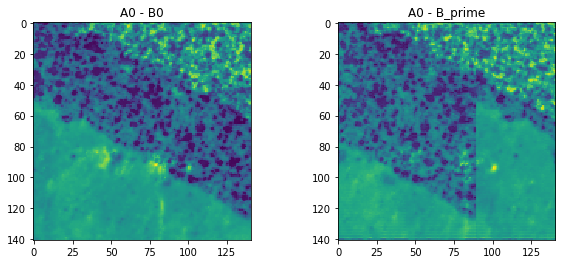

In [515]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.imshow(A0 - B0); ax1.set_title('A0 - B0');
ax2.imshow(A0 - B_prime); ax2.set_title('A0 - B_prime');

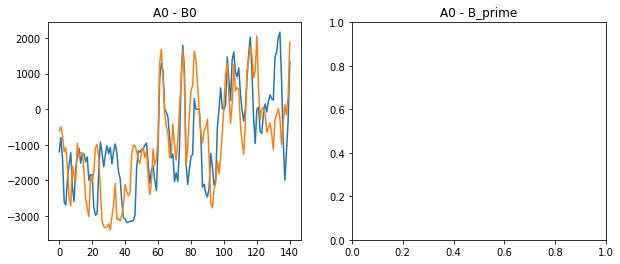

In [516]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot((A0 - B0)[18, :]); ax1.set_title('A0 - B0');
ax1.plot((A0 - B_prime)[18, :]); ax2.set_title('A0 - B_prime');

In [517]:
print('A0 - B0   ', np.var(A0 - B0))
print('A0 - B0(u)', np.var(A0 - B_prime))

a_moins_b_2 = (np.mean(A0) - np.mean(B0))**2
sigma_J = np.mean(A0**2 + B0**2) - a_moins_b_2 + 2*res.fun/A0.size
print('sigma_J   ', sigma_J)

A0 - B0    1305586.6701354727
A0 - B0(u) 1170470.0537234931
sigma_J    1170470.0537234899


In [518]:
D = (A0 - B_prime)

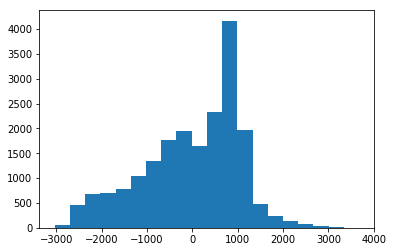

In [519]:
plt.hist((D - np.mean(D)).flatten(), bins=20);

[-0. -0.]


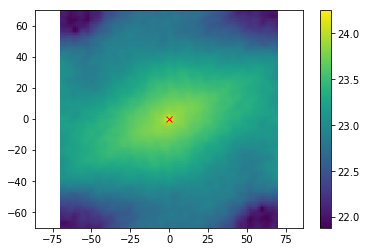

In [520]:
dx_span, dy_span, cross_corr, res = sc.output_cross_correlation(D, D,
                                                                upsamplefactor=1, phase=False)
x_opt = -res.x

argmax_idx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
argmax_idx_cc = argmax_idx 
plt.pcolor(dx_span, dy_span, np.log(cross_corr))
plt.plot(*x_opt[::-1], 'xr'); plt.colorbar();
plt.axis('equal');
print(x_opt[::-1])
#plt.xlim(np.array([-5, 5]) + x_opt[::-1]);
#plt.ylim(np.array([-5, 5]) + x_opt[::-1]);

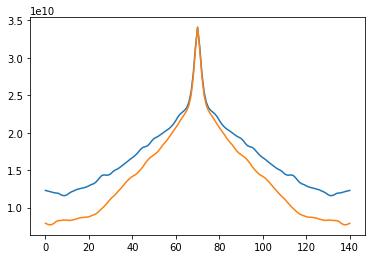

In [521]:
plt.plot(cross_corr[argmax_idx[0], :]);
plt.plot(cross_corr[:, argmax_idx[1]]);

[-0.23930049 -1.34455771]
[-0.1759999  -0.56240178]
[-0.65746953 -1.44852259]
triangle_error 0.5184691865673867
triangle_error 0.5184691865673241


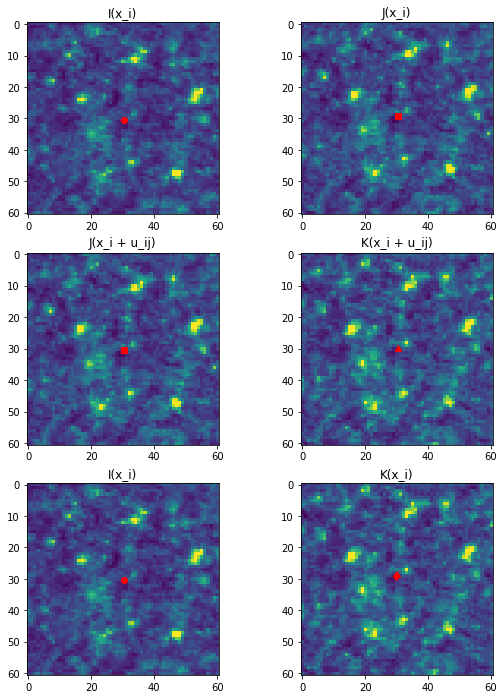

In [152]:
IJK = cube

window_half_size = 30
params = {'window_half_size': window_half_size,
          'coarse_search': False,
          'phase':True,
          'method':'opti' }

I, J, K = IJK
xy_i = points[pts]

u_ij, err_ij = sc.get_shifts(I, J, *xy_i, **params)
print(u_ij)

xy_j = xy_i + u_ij
u_jk, err_jk = sc.get_shifts(J, K, *xy_j, **params)
x_ijk = xy_j + u_jk
print(u_jk)

u_ik, err_ik = sc.get_shifts(I, K, *xy_i, offset=u_ij+u_jk, **params)
x_ik = xy_i + u_ik
C, ij = sc.crop(K, xy_i, window_half_size)
print(u_ik)


fig, axes = plt.subplots(3, 2, figsize=(9,12))

A0, ij = sc.crop(I, xy_i, window_half_size)
B0, ij = sc.crop(J, xy_i, window_half_size)
C0, ij = sc.crop(K, xy_i, window_half_size)

a0 = np.array(A0.shape)/2
b0 = a0 + u_ij[::-1]
c0 = a0 + u_jk[::-1]
c1 = a0 + u_ik[::-1]
c2 = a0 + u_ij[::-1] + u_jk[::-1]

ax1 = axes[0, 0]
ax1.imshow(A0); ax1.plot(*a0[::-1], 'or'); ax1.set_title('I(x_i)');

ax2 = axes[0, 1]
ax2.imshow(B0); ax2.plot(*b0[::-1], 'sr'); ax2.set_title('J(x_i)');

B1, ij = sc.crop(J, xy_j, window_half_size)
C1, ij = sc.crop(K, xy_j, window_half_size)
ax3 = axes[1, 0]
ax3.imshow(B1); ax3.plot(*a0[::-1], 'sr'); ax3.set_title('J(x_i + u_ij)');

ax4 = axes[1, 1]
ax4.imshow(C1); ax4.plot(*c0[::-1], '^r'); ax4.set_title('K(x_i + u_ij)');

ax5 = axes[2, 0]
ax5.imshow(A0); ax5.plot(*a0[::-1], 'or'); ax5.set_title('I(x_i)');

ax6 = axes[2, 1]
ax6.imshow(C0); ax6.plot(*c1[::-1], 'dr'); ax6.set_title('K(x_i)');
ax6.plot(*c2[::-1], '^r');

print('triangle_error', np.sqrt(np.sum((x_ik - x_ijk)**2)))
print('triangle_error', np.sqrt(np.sum((u_ij + u_jk - u_ik)**2)))

In [241]:
displ_to_ref_coarse = sc.integrate_displacement(displ_coarse)
displ_to_ref =  sc.integrate_displacement(displ)

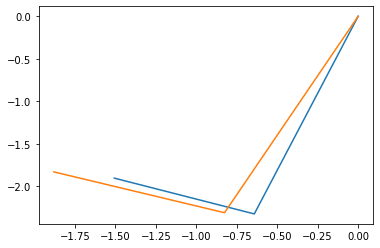

In [242]:
plt.plot(displ_to_ref_coarse[:, 0, 0], displ_to_ref_coarse[:, 0, 1])
plt.plot(displ_to_ref[:, 0, 0], displ_to_ref[:, 0, 1])

In [100]:
ij = 19, 21
I, J = [cube[idx] for idx in ij]

downscale = 2
window_half_size = 80


I, J = [pyramid_reduce(u, downscale=downscale) for u in [I, J]]

xy_i = points[0]/downscale


params = {'window_half_size': window_half_size,
          'coarse_search': False,
          'phase':True,
          'method':'opti' }


A0, ij = sc.crop(I, xy_i, window_half_size)
B0, ij = sc.crop(J, xy_i, window_half_size)

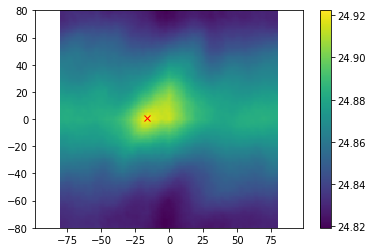

In [101]:
dx_span, dy_span, cross_corr, res = sc.output_cross_correlation(A0, B0,
                                                                upsamplefactor=1, phase=False)

argmax_idx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
argmax_idx_cc = argmax_idx 
plt.pcolor(dx_span, dy_span, np.log(cross_corr))
plt.plot(*argmax[::-1], 'xr'); plt.colorbar();
plt.axis('equal');

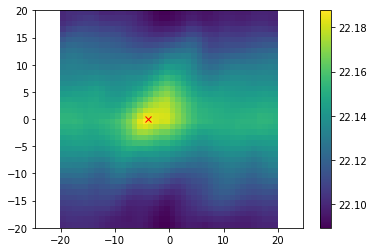

In [99]:
dx_span, dy_span, cross_corr, res = sc.output_cross_correlation(A0, B0,
                                                                upsamplefactor=1, phase=False)

argmax_idx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
argmax_idx_cc = argmax_idx 
plt.pcolor(dx_span, dy_span, np.log(cross_corr))
plt.plot(*argmax[::-1], 'xr'); plt.colorbar();
plt.axis('equal');

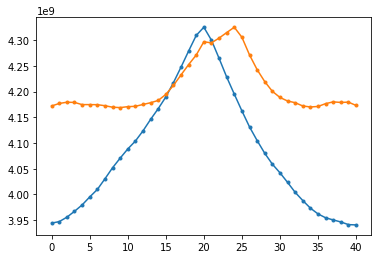

In [98]:
plt.plot(cross_corr[:, argmax_idx[1]], '.-')
plt.plot(cross_corr[argmax_idx[0], :], '.-')